<a href="https://colab.research.google.com/github/takumi19910112/google_colab/blob/main/yama_3_xg_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
####################################
# Library
####################################
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random
import string
import psutil
import pathlib
import datetime
from pathlib import Path
from contextlib import contextmanager
from pprint import pprint
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, train_test_split

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"xgboost.__version__: {xgb.__version__}")

tokenizers.__version__: 0.21.0
xgboost.__version__: 2.1.4


In [18]:
config = SimpleNamespace()

config.exp_name = '001-exp-xgboost'
config.exp_comment = 'xgboost_baseline'
config.seed = 42
config.n_fold = 5
config.num_classes = 3
# XGBoostのMODELパラメータの設定
config.xgb_params = {
    'objective': 'multiclass',
    'num_class': config.num_classes,
    'learning_rate': 0.1,
    'n_estimators': 2000,
    'verbosity': 1,
}
config.eval_rounds = 100
config.stopping_rounds = 200

pprint(config)

namespace(exp_name='001-exp-xgboost',
          exp_comment='xgboost_baseline',
          seed=42,
          n_fold=5,
          num_classes=3,
          xgb_params={'learning_rate': 0.1,
                      'n_estimators': 2000,
                      'num_class': 3,
                      'objective': 'multiclass',
                      'verbosity': 1},
          eval_rounds=100,
          stopping_rounds=200)


In [3]:
OUTPUT_DIR = Path(f'./{config.exp_name}')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

OUTPUT_DIR: 001-exp-xgboost


In [4]:
## 再現性確保のためのSeed固定
def seed_everything(seed:int==42):

    """pythonとosのseedを固定

    Args:
        seed (int, optional): 固定したいseed値. Defaults to =42.
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [5]:
## 処理にかかった時間と使用したメモリを計測
@contextmanager
def timer(name:str, slack:bool=False):

    """処理にかかった時間と使用したメモリを計測
    """

    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield

    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)

    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec")

# 2. Dataのロード

In [6]:
with timer('data load'):

    train_df = pd.read_csv("/content/drive/MyDrive/m_learn/train.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/m_learn/test.csv")
    sub_df = pd.read_csv("/content/drive/MyDrive/m_learn/sample_submission.csv")

    print(f'train: {train_df.shape}')
    print(f'test: {test_df.shape}')
    print(f'sub: {sub_df.shape}')

<< data load >> Start
train: (1233, 3)
test: (828, 3)
sub: (828, 2)
<< data load >> 0.6GB(+0.0GB):1.5sec


In [7]:
# 文字数
train_df['num_characters_text'] = train_df['text'].apply(lambda x: len(x))
test_df['num_characters_text'] = test_df['text'].apply(lambda x: len(x))

# promptの文字数に対するtextの文字数の比
train_df['num_characters_prompt'] = train_df['prompt'].apply(lambda x: len(x))
test_df['num_characters_prompt'] = test_df['prompt'].apply(lambda x: len(x))

train_df['num_characters_ratio'] = train_df['num_characters_text'] / train_df['num_characters_prompt']
test_df['num_characters_ratio'] = test_df['num_characters_text'] / test_df['num_characters_prompt']
train_df

,prompt,text,label,num_characters_text,num_characters_prompt,num_characters_ratio
0,"### Postgres SQL tables, with their properties...",To list the names of departments that employed...,0,381,279,1.365591
1,"### Postgres SQL tables, with their properties...",To list the names of the departments which emp...,1,990,279,3.548387
2,"### Postgres SQL tables, with their properties...",```\nSELECT d.name\nFROM Department d\nJOIN Em...,2,243,279,0.870968
3,**Q**\nIs the following sentence factually cor...,yes,0,3,716,0.004190
4,**Q**\nIs the following sentence factually cor...,"**Q**\nClaim: ""Matthew Shepard died in Laramie...",1,466,716,0.650838
...,...,...,...,...,...,...
1228,write me some python code to pull down docker ...,Here's a simple Python script that can pull do...,1,1198,76,15.763158
1229,write me some python code to pull down docker ...,```python\nimport docker\n\n# Create a Docker ...,2,372,76,4.894737
1230,𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...,This function named def_calc takes one argumen...,0,574,105,5.466667
1231,𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...,Certainly! Here's a detailed docstring for the...,1,907,105,8.638095


In [8]:
# 単語数
# textの単語数
train_df['word_split_text'] = train_df['text'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_words_text'] = train_df['word_split_text'].apply(lambda x: len(x)) # 単語数
test_df['word_split_text'] = test_df['text'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_words_text'] = test_df['word_split_text'].apply(lambda x: len(x)) # 単語数
# promptの単語数
train_df['word_split_prompt'] = train_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_words_prompt'] = train_df['word_split_prompt'].apply(lambda x: len(x)) # 単語数
test_df['word_split_prompt'] = test_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_words_prompt'] = test_df['word_split_prompt'].apply(lambda x: len(x)) # 単語数

# textの単語数とpromptの単語数の比
train_df['num_words_ratio'] = train_df['num_words_text'] / train_df['num_words_prompt']
test_df['num_words_ratio'] = test_df['num_words_text'] / train_df['num_words_prompt']


In [9]:
# textの文章数
train_df['sentence_split_text'] = train_df['text'].apply(lambda x: x.lower().split('.')) # 小文字にしてから単語で分割
train_df['num_sentence_text'] = train_df['sentence_split_text'].apply(lambda x: len(x)) # 単語数
test_df['sentence_split_text'] = test_df['text'].apply(lambda x: x.lower().split('.')) # 小文字にしてから単語で分割
test_df['num_sentence_text'] = test_df['sentence_split_text'].apply(lambda x: len(x)) # 単語数
# promptの単語数
train_df['sentence_split_prompt'] = train_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_sentence_prompt'] = train_df['sentence_split_prompt'].apply(lambda x: len(x)) # 単語数
test_df['sentence_split_prompt'] = test_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_sentence_prompt'] = test_df['sentence_split_prompt'].apply(lambda x: len(x)) # 単語数
# textの単語数とpromptの単語数の比
train_df['num_sentence_ratio'] = train_df['num_sentence_text'] / train_df['num_sentence_prompt']
test_df['num_sentence_ratio'] = test_df['num_sentence_text'] / test_df['num_sentence_prompt']

In [10]:
# promptごとのtextの文字数を集計　→ 特徴量として追加
tmp = train_df.groupby('prompt')['num_characters_text'].agg(['mean', 'max', 'min'])
tmp = tmp.add_prefix('num_characters_text_')
display(tmp.head())

train_df = pd.merge(
    train_df,
    tmp,
    on='prompt',
    how='left'
)
tmp = test_df.groupby('prompt')['num_characters_text'].agg(['mean', 'max', 'min'])
tmp = tmp.add_prefix('num_characters_text_')
display(tmp.head())

test_df = pd.merge(
    test_df,
    tmp,
    on='prompt',
    how='left'
)

num_characters_text_mean  \
prompt                                                                         
### Postgres SQL tables, with their properties:...                538.000000   
**Q**\nIs the following sentence factually corr...                219.000000   
30 students from 5 classes solved 40 math probl...                683.666667   
9616 x 46882?\nOnly mathematical symbols, no ve...                 19.000000   
:\nYou have been given a code snippet that appe...               1218.666667   

                                                    num_characters_text_max  \
prompt                                                                        
### Postgres SQL tables, with their properties:...                      990   
**Q**\nIs the following sentence factually corr...                      466   
30 students from 5 classes solved 40 math probl...                     1080   
9616 x 46882?\nOnly mathematical symbols, no ve...                       26   
:\nYou have been given a code snippet that appe...                     2492   

                                                    num_characters_text_min  
prompt                                                                       
### Postgres SQL tables, with their properties:...                      243  
**Q**\nIs the following sentence factually corr...                        3  
30 students from 5 classes solved 40 math probl...                        2  
9616 x 46882?\nOnly mathematical symbols, no ve...                       11  
:\nYou have been given a code snippet that appe...                      452

,num_characters_text_mean,num_characters_text_max,num_characters_text_min
prompt,,,
"10 positive reasons to move a warehouse facility from Ontario, CA to Las Vegas Nevada.",1419.333333,1761,788
542322 * 3945?\nExclude words; show only the math.,16.333333,26,10
":\n\nYou are given a code snippet that is part of a web application for an online course platform. The snippet is responsible for displaying the number of courses found based on the user type.\n\nThe snippet consists of HTML and embedded PHP code. The PHP code is responsible for determining the number of courses found and the appropriate pluralization of the word ""Course"".\n\nYour task is to write a function that takes in the user type count and course count as input and returns the generated HTML code snippet as a string.\n\nImplement the following function:\n\n```python\ndef generate_course_html(user_type_count: int, course_count: int) -> str:\n pass\n```\n\n**Input:**\n\nThe function takes in two integers:\n- `user_type_count` (1 <= user_type_count <= 100): the number of user types (e.g., instructors, students, etc.).\n- `course_count` (0 <= course_count <= 100): the number of courses found.\n\n**Output:**\n\n- Returns a string containing the HTML code snippet with the appropriate values for `$coursecount` and `$usertypecount`.\n\n**Note:**\n- You may assume that `str_plural` is a custom function already provided, which takes a string as input and returns its pluralized form.\n- The `fa fa-fw fa-book` class is used to display a book icon.",867.666667,1264,410
Adapt the following sentence for the social media post:\nRegular exercise can help maintain a healthy lifestyle.,212.666667,429,98
"Analyze the text below for style, voice, and tone. Using NLP, create a prompt to write a new article in the same style, voice, and tone: Bolsonaro supporters generate chaos in Brasilia, Brazil, with the invasion of the Supreme Court, National Congress and the Planalto Palace on Sunday, January 8. Mateus Bonomi/Anadolu Agency/Getty Images",711.666667,1048,503


In [11]:
# TF-IDFによる特徴量作成
vec = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    analyzer='word',
    ngram_range=(1, 2),
)
train_tfidf = vec.fit_transform([i for i in train_df['text']])
test_tfidf = vec.transform([i for i in test_df['text']])

In [12]:
# train
train_dense_matrix = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(train_dense_matrix)
train_tfidf_df.columns = [f'tfidf_{i}' for i in range(len(train_tfidf_df.columns))]
train_tfidf_df['text'] = train_df['text']
train_df = pd.merge(
    train_df,
    train_tfidf_df,
    on='text',
    how='left'
)

In [13]:
# test
test_dense_matrix = test_tfidf.toarray()
test_tfidf_df = pd.DataFrame(test_dense_matrix)
test_tfidf_df.columns = [f'tfidf_{i}' for i in range(len(test_tfidf_df.columns))]
test_tfidf_df['text'] = test_df['text']
test_df = pd.merge(
    test_df,
    test_tfidf_df,
    on='text',
    how='left'
)

In [14]:
# feature columns & target column
feature_columns = train_df.select_dtypes('number').columns
feature_columns = [c for c in feature_columns if c != 'label']

target_column = 'label'

print(f'features: {len(feature_columns):,}')

features: 4,830


In [15]:
train_df['fold'] = -1
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, va_idx) in enumerate(skf.split(train_df, train_df['label'])):

    train_df.loc[va_idx, 'fold'] = fold+1

train_df['fold'] = train_df['fold'].astype('int')

pd.pivot_table(train_df, index='fold', columns='label', values='prompt', aggfunc='count')

label,0,1,2
fold,,,
1,83,82,82
2,82,83,82
3,82,82,83
4,82,82,83
5,82,82,83


# 4.Training

In [16]:
def f1(y_true, y_pred):
    N_LABELS = 3
    y_pred_ = y_pred.argmax(axis=1)
    score = f1_score(y_true, y_pred_, average='macro')
    return 'f1', score, True

oof_prob = np.zeros((len(train_df), config.num_classes))
imp_dfs = []

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 各foldの混同行列を表示する関数
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    return cm

★★★★ fold 1 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99191	validation_1-mlogloss:1.02806
[1]	validation_0-mlogloss:0.89945	validation_1-mlogloss:0.96892
[2]	validation_0-mlogloss:0.81919	validation_1-mlogloss:0.91726
[3]	validation_0-mlogloss:0.74964	validation_1-mlogloss:0.87605
[4]	validation_0-mlogloss:0.68868	validation_1-mlogloss:0.84040
[5]	validation_0-mlogloss:0.63469	validation_1-mlogloss:0.80847
[6]	validation_0-mlogloss:0.58613	validation_1-mlogloss:0.78145
[7]	validation_0-mlogloss:0.54323	validation_1-mlogloss:0.75928
[8]	validation_0-mlogloss:0.50456	validation_1-mlogloss:0.73651
[9]	validation_0-mlogloss:0.46793	validation_1-mlogloss:0.71896
[10]	validation_0-mlogloss:0.43599	validation_1-mlogloss:0.70060
[11]	validation_0-mlogloss:0.40693	validation_1-mlogloss:0.68552
[12]	validation_0-mlogloss:0.37916	validation_1-mlogloss:0.67203
[13]	validation_0-mlogloss:0.35487	validation_1-mlogloss:0.65936
[14]	validation_0-mlogloss:0.33168	validation_1-mlogloss

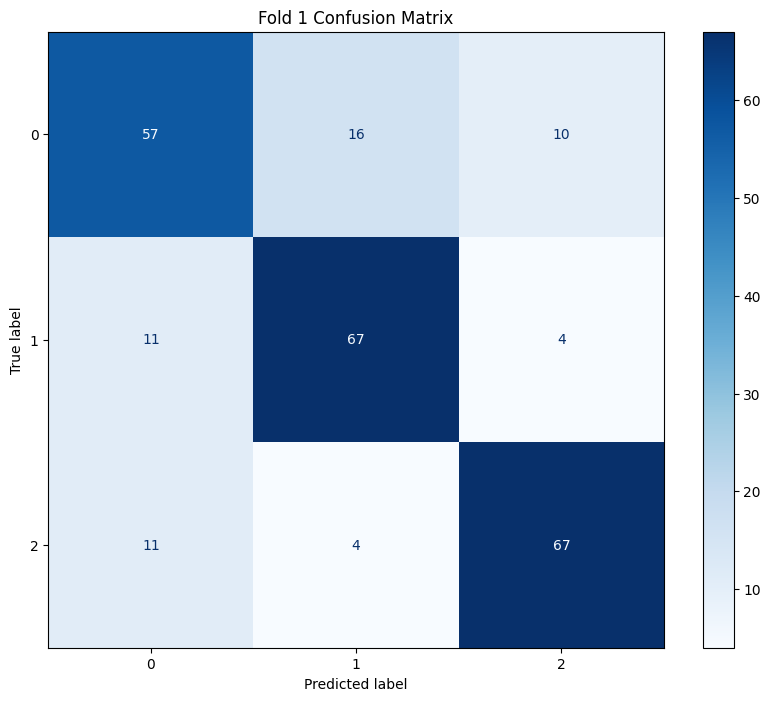

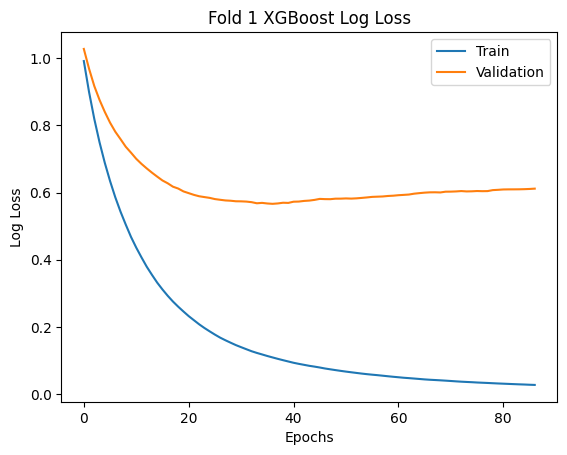

★★★★ fold 2 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99368	validation_1-mlogloss:1.02804
[1]	validation_0-mlogloss:0.90400	validation_1-mlogloss:0.97113
[2]	validation_0-mlogloss:0.82574	validation_1-mlogloss:0.92220
[3]	validation_0-mlogloss:0.75716	validation_1-mlogloss:0.87784
[4]	validation_0-mlogloss:0.69630	validation_1-mlogloss:0.83920
[5]	validation_0-mlogloss:0.64267	validation_1-mlogloss:0.80549
[6]	validation_0-mlogloss:0.59378	validation_1-mlogloss:0.77441
[7]	validation_0-mlogloss:0.55007	validation_1-mlogloss:0.74902
[8]	validation_0-mlogloss:0.51095	validation_1-mlogloss:0.72689
[9]	validation_0-mlogloss:0.47566	validation_1-mlogloss:0.70749
[10]	validation_0-mlogloss:0.44309	validation_1-mlogloss:0.68973
[11]	validation_0-mlogloss:0.41268	validation_1-mlogloss:0.67213
[12]	validation_0-mlogloss:0.38532	validation_1-mlogloss:0.65704
[13]	validation_0-mlogloss:0.36022	validation_1-mlogloss:0.64481
[14]	validation_0-mlogloss:0.33650	validation_1-mlogloss

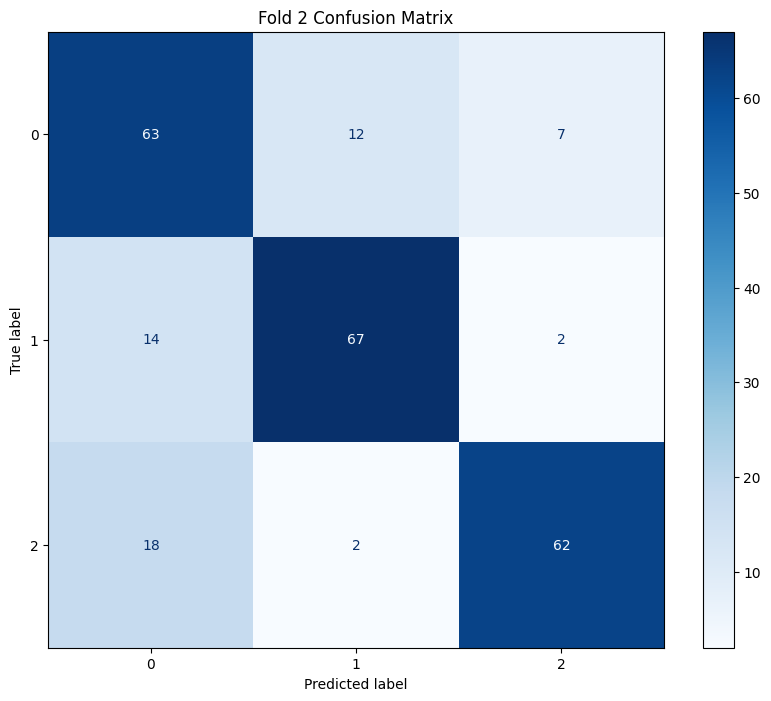

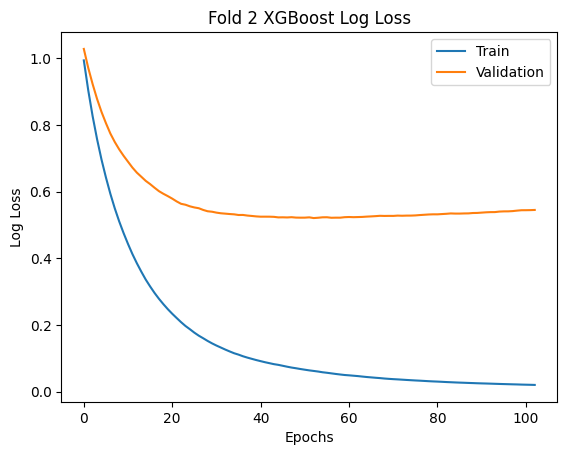

★★★★ fold 3 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99685	validation_1-mlogloss:1.02818
[1]	validation_0-mlogloss:0.90906	validation_1-mlogloss:0.96521
[2]	validation_0-mlogloss:0.83243	validation_1-mlogloss:0.91065
[3]	validation_0-mlogloss:0.76531	validation_1-mlogloss:0.86315
[4]	validation_0-mlogloss:0.70699	validation_1-mlogloss:0.82083
[5]	validation_0-mlogloss:0.65427	validation_1-mlogloss:0.78750
[6]	validation_0-mlogloss:0.60519	validation_1-mlogloss:0.75801
[7]	validation_0-mlogloss:0.56164	validation_1-mlogloss:0.72896
[8]	validation_0-mlogloss:0.52235	validation_1-mlogloss:0.70578
[9]	validation_0-mlogloss:0.48687	validation_1-mlogloss:0.68556
[10]	validation_0-mlogloss:0.45358	validation_1-mlogloss:0.66636
[11]	validation_0-mlogloss:0.42399	validation_1-mlogloss:0.64932
[12]	validation_0-mlogloss:0.39697	validation_1-mlogloss:0.63239
[13]	validation_0-mlogloss:0.37252	validation_1-mlogloss:0.61934
[14]	validation_0-mlogloss:0.34950	validation_1-mlogloss

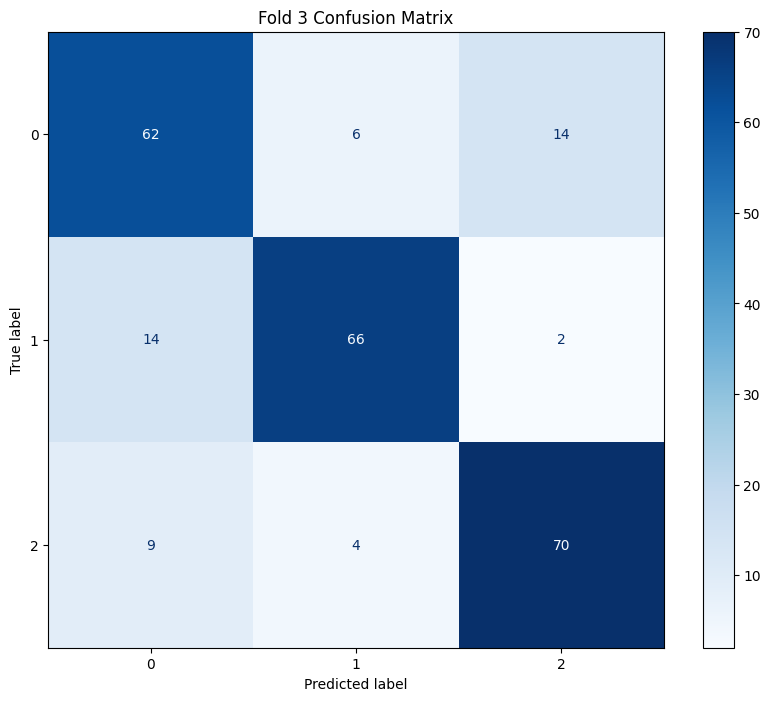

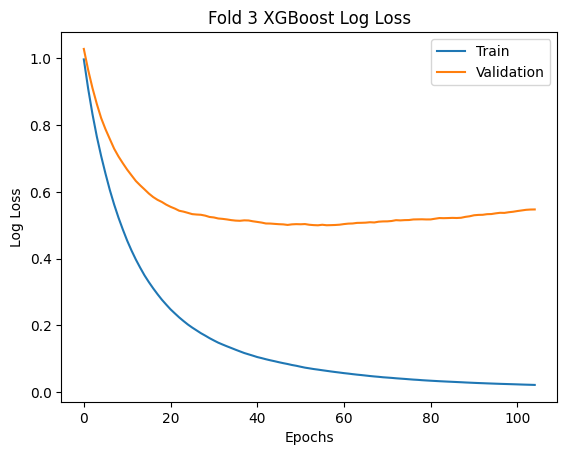

★★★★ fold 4 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99630	validation_1-mlogloss:1.03015
[1]	validation_0-mlogloss:0.90900	validation_1-mlogloss:0.97209
[2]	validation_0-mlogloss:0.83501	validation_1-mlogloss:0.92153
[3]	validation_0-mlogloss:0.76913	validation_1-mlogloss:0.87833
[4]	validation_0-mlogloss:0.70734	validation_1-mlogloss:0.83700
[5]	validation_0-mlogloss:0.65344	validation_1-mlogloss:0.79943
[6]	validation_0-mlogloss:0.60398	validation_1-mlogloss:0.76566
[7]	validation_0-mlogloss:0.55943	validation_1-mlogloss:0.73807
[8]	validation_0-mlogloss:0.51979	validation_1-mlogloss:0.71123
[9]	validation_0-mlogloss:0.48417	validation_1-mlogloss:0.69094
[10]	validation_0-mlogloss:0.45052	validation_1-mlogloss:0.67001
[11]	validation_0-mlogloss:0.42117	validation_1-mlogloss:0.65367
[12]	validation_0-mlogloss:0.39267	validation_1-mlogloss:0.63869
[13]	validation_0-mlogloss:0.36763	validation_1-mlogloss:0.62433
[14]	validation_0-mlogloss:0.34473	validation_1-mlogloss

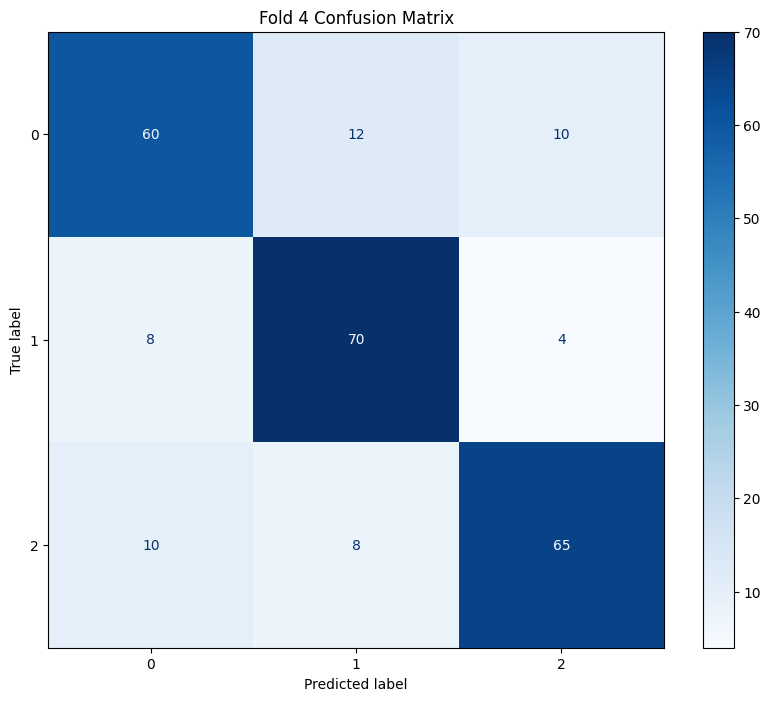

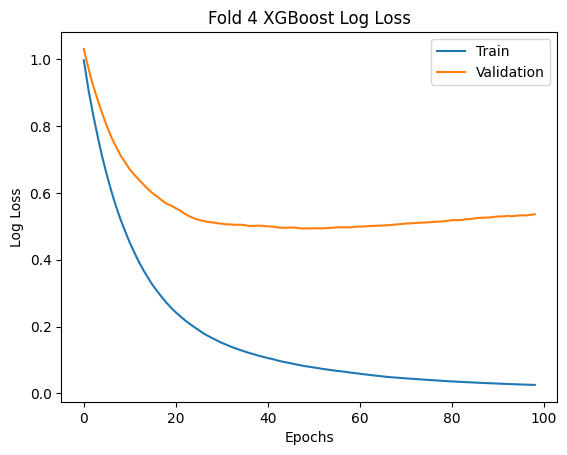

★★★★ fold 5 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99511	validation_1-mlogloss:1.02298
[1]	validation_0-mlogloss:0.90593	validation_1-mlogloss:0.96074
[2]	validation_0-mlogloss:0.82726	validation_1-mlogloss:0.90980
[3]	validation_0-mlogloss:0.76100	validation_1-mlogloss:0.86532
[4]	validation_0-mlogloss:0.70154	validation_1-mlogloss:0.82674
[5]	validation_0-mlogloss:0.64759	validation_1-mlogloss:0.78876
[6]	validation_0-mlogloss:0.59692	validation_1-mlogloss:0.75796
[7]	validation_0-mlogloss:0.55345	validation_1-mlogloss:0.72854
[8]	validation_0-mlogloss:0.51437	validation_1-mlogloss:0.70620
[9]	validation_0-mlogloss:0.47826	validation_1-mlogloss:0.68083
[10]	validation_0-mlogloss:0.44590	validation_1-mlogloss:0.66176
[11]	validation_0-mlogloss:0.41526	validation_1-mlogloss:0.64371
[12]	validation_0-mlogloss:0.38691	validation_1-mlogloss:0.62865
[13]	validation_0-mlogloss:0.36192	validation_1-mlogloss:0.61564
[14]	validation_0-mlogloss:0.33818	validation_1-mlogloss

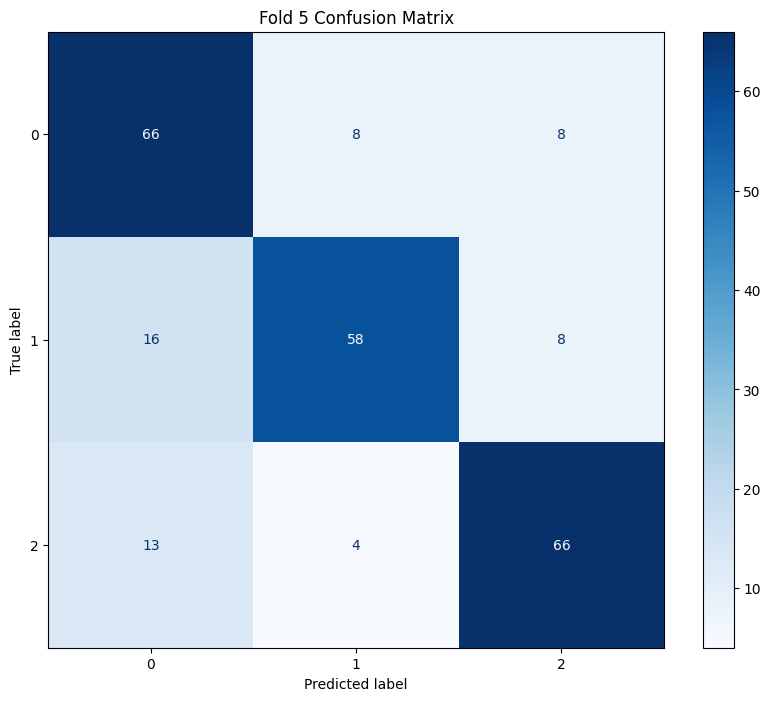

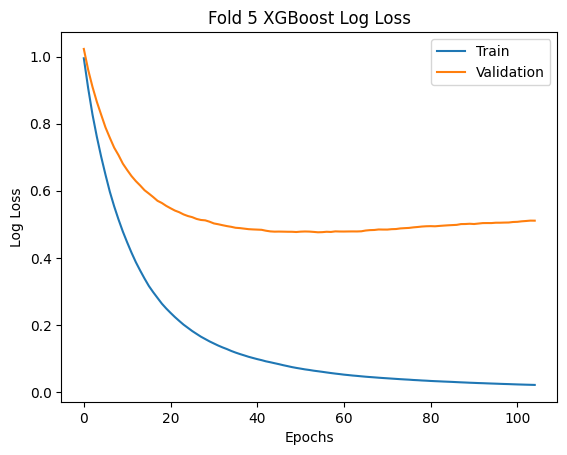

In [36]:
# クロスバリデーションのループ
for fold in range(config.n_fold):

    print(f'★★★★ fold {fold + 1} ★★★★')
    seed_everything(config.seed)

    # Train, Validation のデータ分割
    X_train = train_df.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')
    y_train = X_train[target_column]
    X_train = X_train[feature_columns]

    y_valid = X_valid[target_column]
    X_valid = X_valid[feature_columns]

    # モデルの作成とコールバック
    model = XGBClassifier(
        **config.xgb_params,
        early_stopping_rounds=50
    )

    # モデルの訓練
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
    )

    # 予測
    # 最適なイテレーション数で予測
    pred_val = model.predict_proba(X_valid, iteration_range=(0, model.best_iteration + 1))
    pred_class = pred_val.argmax(axis=1)
    oof_prob[valid_idx] += pred_val
    valid_score = f1_score(
        y_valid,
        pred_val.argmax(axis=1),
        average='macro'
    )
    print(f"Fold {fold + 1} | Valid_score: {valid_score:.5f}")
    # 混同行列の表示
    print(f"Fold {fold + 1} の混同行列:")
    cm = plot_confusion_matrix(y_valid, pred_class, title=f'Fold {fold + 1} Confusion Matrix')

    # 特徴量重要度の取得
    importances = pd.DataFrame()
    importances["feature"] = feature_columns
    importances["gain"] = model.feature_importances_
    importances["fold"] = fold + 1
    imp_dfs.append(importances)

    # モデルの保存
    model.save_model(f'./xgboost_fold_{fold + 1}.json')
    # 学習曲線
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title(f'Fold {fold + 1} XGBoost Log Loss')
    plt.show()

In [37]:
# CV Score
F1Score = f1_score(train_df['label'], np.argmax(oof_prob, axis=1), average='macro')
print(f'CV Score: {F1Score:.5f}')

CV Score: 0.78844


全体の混同行列:


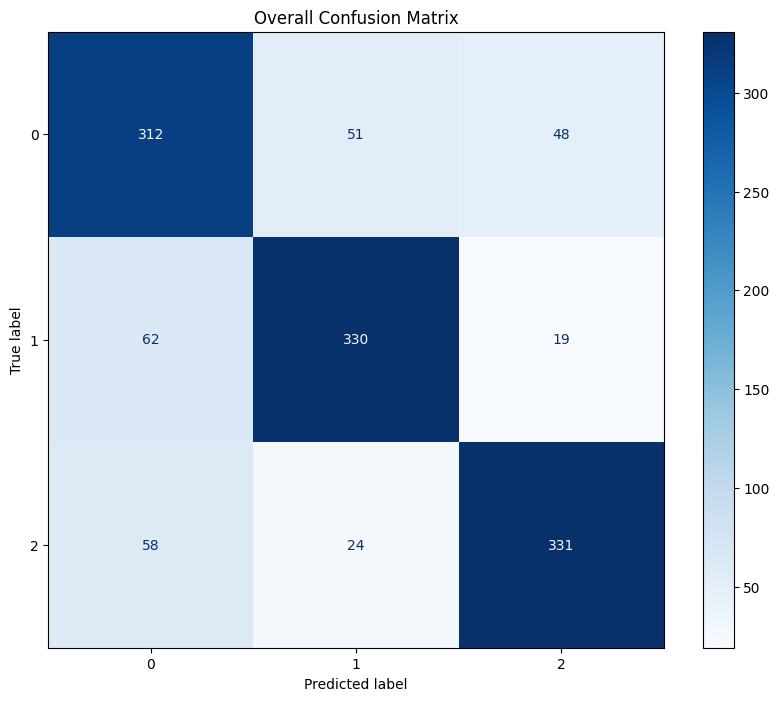

クラス 0 の精度: 0.7591
クラス 1 の精度: 0.8029
クラス 2 の精度: 0.8015


In [38]:
# 全体の予測クラスを取得
y_true = train_df[target_column]
y_pred = np.argmax(oof_prob, axis=1)

# 全体の混同行列を表示
print("全体の混同行列:")
cm_all = plot_confusion_matrix(y_true, y_pred, title='Overall Confusion Matrix')

# クラスごとの精度を計算
class_accuracy = cm_all.diagonal() / cm_all.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"クラス {i} の精度: {acc:.4f}")

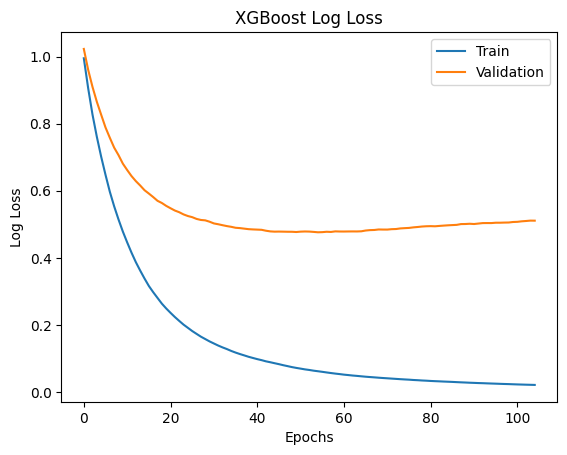

In [39]:
# 学習曲線のプロット
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

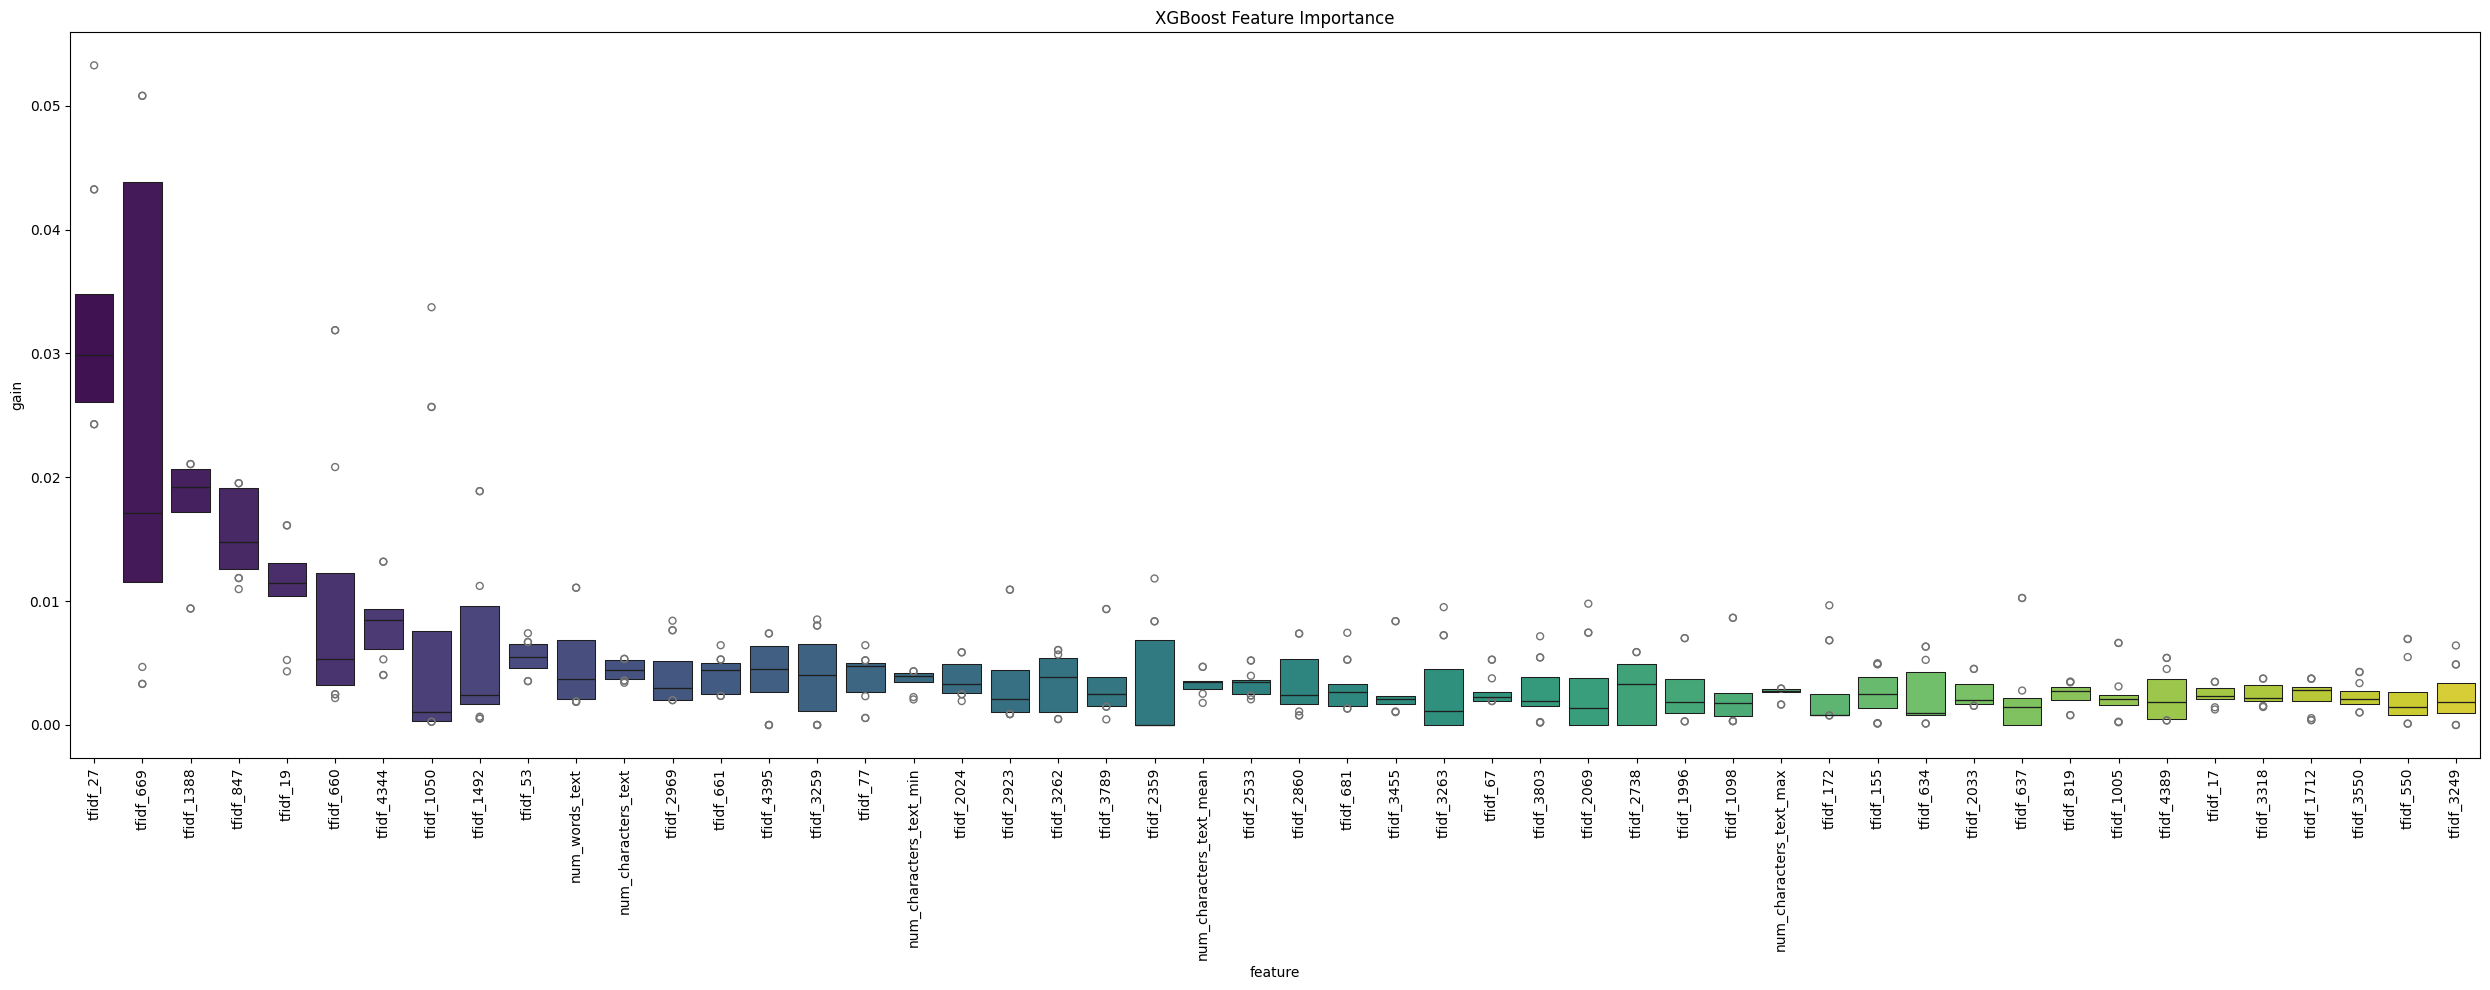

In [40]:
IMP_DF = pd.concat(imp_dfs, axis=0, ignore_index=True)
# 特徴量の平均重要度を計算して上位を選択
feature_importance = IMP_DF.groupby('feature').mean()[['gain']].sort_values('gain', ascending=False)
order = IMP_DF.groupby('feature').sum()[['gain']].sort_values('gain', ascending=False).index[:50]
plt.figure(figsize=(25, 10), tight_layout=True)
sns.boxenplot(data=IMP_DF,x='feature', y='gain', order=order,  palette='viridis')
plt.xticks(rotation=90)
plt.title(f"XGBoost Feature Importance")
plt.show()

In [26]:
# 重要な特徴量のみを選択
# 方法1: 上位N個の特徴量を選択
N = 10  # 例：上位10個
selected_features = feature_importance.index[:N].tolist()

# または方法2: 閾値以上の特徴量を選択
# threshold = 0.005  # 例：重要度0.5%以上
# selected_features = feature_importance[feature_importance['gain'] >= threshold].index.tolist()

print(f"選択された特徴量数: {len(selected_features)}")
print(f"選択された特徴量: {selected_features}")

選択された特徴量数: 10
選択された特徴量: ['tfidf_27', 'tfidf_669', 'tfidf_1388', 'tfidf_847', 'tfidf_660', 'tfidf_19', 'tfidf_1050', 'tfidf_4344', 'tfidf_1492', 'tfidf_53']


★★★★ 特徴量選択後 fold 1 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:1.02010	validation_1-mlogloss:1.03202
[1]	validation_0-mlogloss:0.95355	validation_1-mlogloss:0.97543
[2]	validation_0-mlogloss:0.89555	validation_1-mlogloss:0.92785
[3]	validation_0-mlogloss:0.84652	validation_1-mlogloss:0.88799
[4]	validation_0-mlogloss:0.80322	validation_1-mlogloss:0.85452
[5]	validation_0-mlogloss:0.76516	validation_1-mlogloss:0.82437
[6]	validation_0-mlogloss:0.73187	validation_1-mlogloss:0.79950
[7]	validation_0-mlogloss:0.70239	validation_1-mlogloss:0.77697
[8]	validation_0-mlogloss:0.67542	validation_1-mlogloss:0.75844
[9]	validation_0-mlogloss:0.65101	validation_1-mlogloss:0.74144
[10]	validation_0-mlogloss:0.62915	validation_1-mlogloss:0.72728
[11]	validation_0-mlogloss:0.60946	validation_1-mlogloss:0.71607
[12]	validation_0-mlogloss:0.59121	validation_1-mlogloss:0.70474
[13]	validation_0-mlogloss:0.57543	validation_1-mlogloss:0.69574
[14]	validation_0-mlogloss:0.56105	validation_1-m

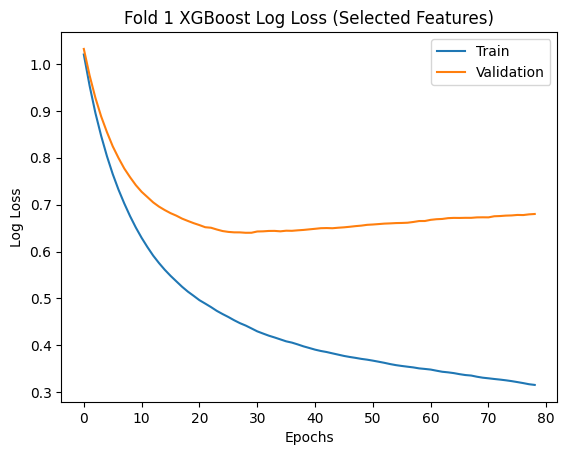

★★★★ 特徴量選択後 fold 2 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:1.01912	validation_1-mlogloss:1.03378
[1]	validation_0-mlogloss:0.95224	validation_1-mlogloss:0.97879
[2]	validation_0-mlogloss:0.89492	validation_1-mlogloss:0.93375
[3]	validation_0-mlogloss:0.84536	validation_1-mlogloss:0.89533
[4]	validation_0-mlogloss:0.80203	validation_1-mlogloss:0.86349
[5]	validation_0-mlogloss:0.76396	validation_1-mlogloss:0.83671
[6]	validation_0-mlogloss:0.73101	validation_1-mlogloss:0.81297
[7]	validation_0-mlogloss:0.70213	validation_1-mlogloss:0.79251
[8]	validation_0-mlogloss:0.67590	validation_1-mlogloss:0.77353
[9]	validation_0-mlogloss:0.65187	validation_1-mlogloss:0.75706
[10]	validation_0-mlogloss:0.62946	validation_1-mlogloss:0.74274
[11]	validation_0-mlogloss:0.61022	validation_1-mlogloss:0.73054
[12]	validation_0-mlogloss:0.59222	validation_1-mlogloss:0.71953
[13]	validation_0-mlogloss:0.57639	validation_1-mlogloss:0.71025
[14]	validation_0-mlogloss:0.56191	validation_1-m

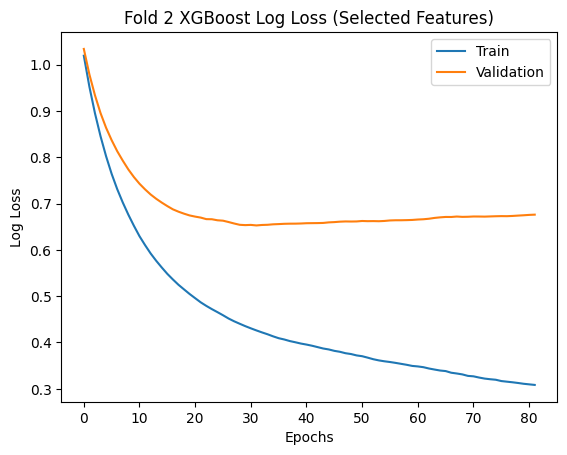

★★★★ 特徴量選択後 fold 3 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:1.02017	validation_1-mlogloss:1.02975
[1]	validation_0-mlogloss:0.95487	validation_1-mlogloss:0.97307
[2]	validation_0-mlogloss:0.89831	validation_1-mlogloss:0.92527
[3]	validation_0-mlogloss:0.84952	validation_1-mlogloss:0.88414
[4]	validation_0-mlogloss:0.80717	validation_1-mlogloss:0.84878
[5]	validation_0-mlogloss:0.76996	validation_1-mlogloss:0.81772
[6]	validation_0-mlogloss:0.73674	validation_1-mlogloss:0.79199
[7]	validation_0-mlogloss:0.70783	validation_1-mlogloss:0.76969
[8]	validation_0-mlogloss:0.68146	validation_1-mlogloss:0.75048
[9]	validation_0-mlogloss:0.65677	validation_1-mlogloss:0.73322
[10]	validation_0-mlogloss:0.63563	validation_1-mlogloss:0.71791
[11]	validation_0-mlogloss:0.61606	validation_1-mlogloss:0.70556
[12]	validation_0-mlogloss:0.59804	validation_1-mlogloss:0.69407
[13]	validation_0-mlogloss:0.58215	validation_1-mlogloss:0.68461
[14]	validation_0-mlogloss:0.56687	validation_1-m

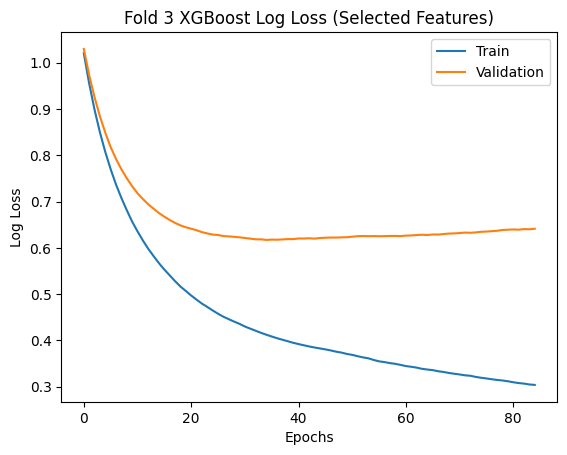

★★★★ 特徴量選択後 fold 4 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:1.02053	validation_1-mlogloss:1.02921
[1]	validation_0-mlogloss:0.95456	validation_1-mlogloss:0.97235
[2]	validation_0-mlogloss:0.89780	validation_1-mlogloss:0.92494
[3]	validation_0-mlogloss:0.84864	validation_1-mlogloss:0.88577
[4]	validation_0-mlogloss:0.80511	validation_1-mlogloss:0.85157
[5]	validation_0-mlogloss:0.76720	validation_1-mlogloss:0.82113
[6]	validation_0-mlogloss:0.73444	validation_1-mlogloss:0.79556
[7]	validation_0-mlogloss:0.70482	validation_1-mlogloss:0.77314
[8]	validation_0-mlogloss:0.67872	validation_1-mlogloss:0.75551
[9]	validation_0-mlogloss:0.65460	validation_1-mlogloss:0.73788
[10]	validation_0-mlogloss:0.63280	validation_1-mlogloss:0.72305
[11]	validation_0-mlogloss:0.61315	validation_1-mlogloss:0.71028
[12]	validation_0-mlogloss:0.59502	validation_1-mlogloss:0.69821
[13]	validation_0-mlogloss:0.57956	validation_1-mlogloss:0.68828
[14]	validation_0-mlogloss:0.56482	validation_1-m

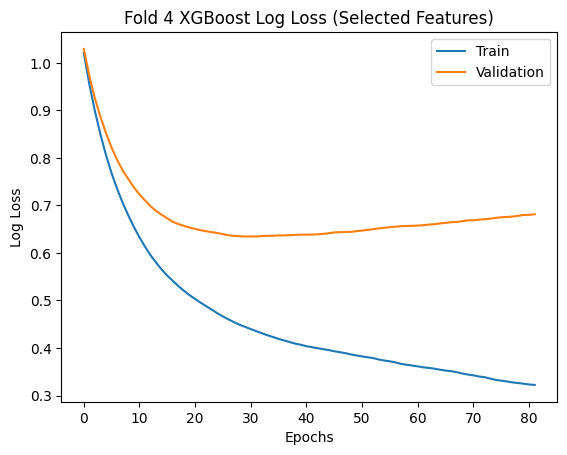

★★★★ 特徴量選択後 fold 5 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:1.01981	validation_1-mlogloss:1.02723
[1]	validation_0-mlogloss:0.95352	validation_1-mlogloss:0.96908
[2]	validation_0-mlogloss:0.89698	validation_1-mlogloss:0.91744
[3]	validation_0-mlogloss:0.84813	validation_1-mlogloss:0.87571
[4]	validation_0-mlogloss:0.80529	validation_1-mlogloss:0.83779
[5]	validation_0-mlogloss:0.76756	validation_1-mlogloss:0.80467
[6]	validation_0-mlogloss:0.73480	validation_1-mlogloss:0.77649
[7]	validation_0-mlogloss:0.70541	validation_1-mlogloss:0.75082
[8]	validation_0-mlogloss:0.67892	validation_1-mlogloss:0.73010
[9]	validation_0-mlogloss:0.65481	validation_1-mlogloss:0.71119
[10]	validation_0-mlogloss:0.63308	validation_1-mlogloss:0.69478
[11]	validation_0-mlogloss:0.61337	validation_1-mlogloss:0.68069
[12]	validation_0-mlogloss:0.59601	validation_1-mlogloss:0.66832
[13]	validation_0-mlogloss:0.58000	validation_1-mlogloss:0.65733
[14]	validation_0-mlogloss:0.56570	validation_1-m

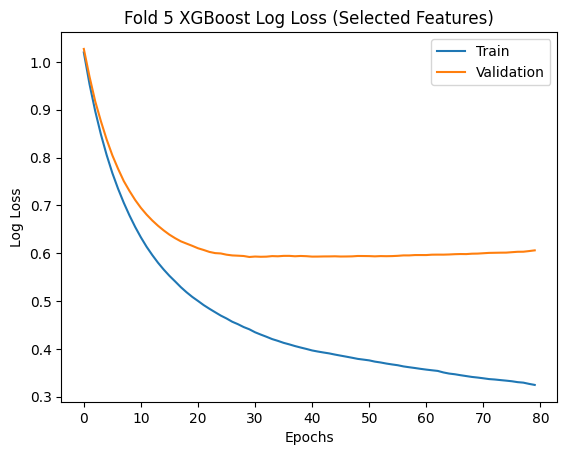

特徴量選択後のCV Score: 0.74691
特徴量選択前のCV Score: 0.78844
特徴量選択後のCV Score: 0.74691
改善率: -5.27%


In [31]:
# 特徴量選択後のクロスバリデーション
oof_prob_selected = np.zeros((len(train_df), config.num_classes))  # num_classをnum_classesに修正
imp_dfs_selected = []  # 新しいリストを作成

for fold in range(config.n_fold):
    print(f'★★★★ 特徴量選択後 fold {fold + 1} ★★★★')
    seed_everything(config.seed)

    # Train, Validation のデータ分割
    X_train = train_df.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')
    y_train = X_train[target_column]
    X_train = X_train[selected_features]  # 選択された特徴量のみ使用

    y_valid = X_valid[target_column]
    X_valid = X_valid[selected_features]  # 選択された特徴量のみ使用

    # モデルの作成とコールバック
    model = XGBClassifier(
        **config.xgb_params,
        early_stopping_rounds=50
    )

    # モデルの訓練
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
    )

    # 予測
    # 最適なイテレーション数で予測
    pred_val = model.predict_proba(X_valid, iteration_range=(0, model.best_iteration + 1))
    oof_prob_selected[valid_idx] += pred_val  # oof_prob_selectedを使用
    valid_score = f1_score(
        y_valid,
        pred_val.argmax(axis=1),
        average='macro'
    )
    print(f"Fold {fold + 1} | Valid_score: {valid_score:.5f}")

    # 特徴量重要度の取得
    importances = pd.DataFrame()
    importances["feature"] = selected_features  # 修正: selected_featuresを使用
    importances["gain"] = model.feature_importances_
    importances["fold"] = fold + 1
    imp_dfs_selected.append(importances)  # imp_dfs_selectedに追加

    # モデルの保存
    model.save_model(f'./xgboost_selected_fold_{fold + 1}.json')  # ファイル名を変更

    # 学習曲線
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title(f'Fold {fold + 1} XGBoost Log Loss (Selected Features)')
    plt.show()

# 特徴量選択後のCVスコア
F1Score_selected = f1_score(train_df['label'], np.argmax(oof_prob_selected, axis=1), average='macro')
print(f'特徴量選択後のCV Score: {F1Score_selected:.5f}')

# 特徴量選択前後のスコア比較
print(f'特徴量選択前のCV Score: {F1Score:.5f}')
print(f'特徴量選択後のCV Score: {F1Score_selected:.5f}')
print(f'改善率: {(F1Score_selected - F1Score) / F1Score * 100:.2f}%')

In [34]:
# 特徴量選択前の予測クラス
y_pred_before = np.argmax(oof_prob, axis=1)

# 特徴量選択後の予測クラス
y_pred_after = np.argmax(oof_prob_selected, axis=1)

# 特徴量選択前の混同行列
print("特徴量選択前の混同行列:")
cm_before = plot_confusion_matrix(y_true, y_pred_before, title='Confusion Matrix (Before Feature Selection)')

# 特徴量選択後の混同行列
print("特徴量選択後の混同行列:")
cm_after = plot_confusion_matrix(y_true, y_pred_after, title='Confusion Matrix (After Feature Selection)')

# クラスごとの変化を分析
print("\nクラスごとの精度変化:")
class_acc_before = cm_before.diagonal() / cm_before.sum(axis=1)
class_acc_after = cm_after.diagonal() / cm_after.sum(axis=1)

for i, (acc_before, acc_after) in enumerate(zip(class_acc_before, class_acc_after)):
    change = (acc_after - acc_before) / acc_before * 100
    print(f"クラス {i}: {acc_before:.4f} → {acc_after:.4f} (変化率: {change:.2f}%)")

特徴量選択前の混同行列:


NameError: name 'y_true' is not defined

In [ ]:
sub_df['label'] = np.argmax(test_prob, axis=1)
sub_df.to_csv(OUTPUT_DIR / f'{config.exp_name}_{F1Score:.5f}_submission.csv', index=False)